# PortfolioBuilder

### Purpose
This Jupyter Notebook is specifically designed to analyze the financial performance and health of selected companies with the goal of determining their potential value as additions to an investment portfolio. By examining key financial metrics and trends, this notebook aims to provide an in-depth understanding and a data-driven approach to aid in making informed investment decisions. The analysis will cover various financial aspects including profitability, liquidity, and growth potential, which are critical for assessing whether a company stands as a promising investment opportunity.


### How to Use This Notebook
To use this notebook effectively, you will need to set up a specific Python environment which includes all the necessary libraries and their dependencies. Follow these steps to prepare your environment:

#### Step 1: Clone the Repository
If applicable, clone the repository containing this notebook and associated files (like the environment file) to your local machine using:
```bash
git clone [URL-to-your-repository]
```

#### Step 2: Create the env
Use the following commands to create and activate the Conda environment from the YAML file included in the directory `conda`:
```bash
cd conda
conda env create -f notebooks_portfolio_builder.yml
```

#### Step 3: Activating the env
```bash
conda activate portfolio_builder
```

### Author
- Name: Mauro Andretta
- Date Created: 2024/07/25
- Contact: mauo.andretta222@gmail.com

In [34]:
# Import necessary libraries
import yfinance as yf
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
import pandas as pd
import os
import time

# read config file
import configparser

# progress bar
import pyprind

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config.ini file
config.read('config.ini')

# Retrieve the paths from the config file
csv_folder = config.get('Paths', 'csv_folder')
excel_folder = config.get('Paths', 'excel_folder')

In [3]:
# check if the csv and excel folder exists
# if not create them
try:
    if not os.path.exists(csv_folder):
        os.makedirs(csv_folder)
        print(f"Directory {csv_folder} created")
    else:
        print(f"Directory {csv_folder} already exists")
    
except Exception as e:
    print(f"An error occurred: {e}")

try:
    if not os.path.exists(excel_folder):
        os.makedirs(excel_folder)
        print(f"Directory {excel_folder} created")
    else:
        print(f"Directory {excel_folder} already exists")
    
except Exception as e:
    print(f"An error occurred: {e}")

Directory companies_data/csv_files already exists
Directory companies_data/excel_files already exists


# Fetch stock data

In [4]:
def save_company_data_to_csv(ticker_symbol: str, company_data: dict, root_dir: str) -> None:
    """
    This function takes a stock ticker as input and saves the company data to a CSV file.
    Args:
        ticker_symbol (str): The stock ticker of the company for which the data is to be fetched.
        company_data (dict): A dictionary containing different types of financial data for the given stock ticker.
    """

    # Create the root directory if it does not exist
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)

    # Create a directory for the company if it does not exist
    company_dir = os.path.join(root_dir, ticker_symbol)
    if not os.path.exists(company_dir):
        os.makedirs(company_dir)

    # Iterate over the dictionary and save each item to a CSV file
    for key, value in company_data.items():
        if isinstance(value, pd.DataFrame):
            file_path = os.path.join(company_dir, f"{key}.csv")
            value.to_csv(file_path)
            #print(f"Saved {key}.csv in {company_dir}/")
    
    

In [5]:

def csv_to_excel(root_csv_dir: str, root_excel_dir:str) -> None:
    """
    This function converts all CSV files in a directory to Excel files and saves them in a corresponding directory structure.

    Args:
        root_csv_dir (str): The root directory containing the CSV files.
        root_excel_dir (str): The root directory where the Excel files will be saved.
    """
    # Check if the root Excel directory exists, if not, create it
    if not os.path.exists(root_excel_dir):
        os.makedirs(root_excel_dir)
        print(f"Created directory: {root_excel_dir}")

    # Walk through all directories and files in the root CSV directory
    for subdir, dirs, files in os.walk(root_csv_dir):
        for file in files:
            if file.endswith(".csv"):
                # Construct CSV file path
                csv_file_path = os.path.join(subdir, file)
                
                # Read the CSV file
                df = pd.read_csv(csv_file_path)
                
                # Create a corresponding Excel directory structure
                relative_path = os.path.relpath(subdir, root_csv_dir)  # Relative path from CSV root
                excel_dir = os.path.join(root_excel_dir, relative_path)
                if not os.path.exists(excel_dir):
                    os.makedirs(excel_dir)
                    print(f"Created directory: {excel_dir}")
                
                # Construct Excel file path
                excel_file_path = os.path.join(excel_dir, file.replace(".csv", ".xlsx"))
                
                # Save the DataFrame to an Excel file
                df.to_excel(excel_file_path, index=False, engine='openpyxl')
                #print(f"Saved Excel file at: {excel_file_path}")


In [6]:
# Define the custom session class with caching, rate limiting, and retry mechanism
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

# Initialize the session with increased timeout and retry settings
def create_session():
    session = CachedLimiterSession(
        limiter=Limiter(RequestRate(2, Duration.SECOND*10)),  # max 2 requests per 10 seconds
        bucket_class=MemoryQueueBucket,
        backend=SQLiteCache("yfinance.cache"),
    )
    
    # Set a custom User-Agent if desired
    session.headers['User-agent'] = 'my-program/1.0'

    return session

# Create a global session instance
session = create_session()

In [7]:
def get_company_data(ticker_symbol: str, period: str, session: CachedLimiterSession) -> dict:
    """
    This function takes a stock ticker as input and returns a dictionary containing different types of financial data.

    Parameters:
    ticker (str): The stock ticker of the company for which the data is to be fetched.
    period (str): The period for which the data is to be fetched. It can be one of the following options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max.

    Returns:
    dict: A dictionary containing different types of financial data for the given stock ticker.
    """
    # check if the period is valid
    if period not in ["1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"]:
        raise ValueError("Invalid period. Please enter a valid period from the following options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max")
    
    try:
        # get all stock info
        company = yf.Ticker(ticker_symbol, session=session)
        
        # get historical market data
        info = company.info

        # show meta information about the history 
        historical_data = company.history(period=period)
        actions = company.actions
        dividends = company.dividends
        splits = company.splits
        capital_gains = company.capital_gains

        # show financials:
        # - financials
        financials = company.financials
        quarterly_financials = company.quarterly_financials
        # - income statement
        income_stmt = company.income_stmt
        quarterly_income_stmt = company.quarterly_income_stmt
        # - balance sheet
        balance_sheet = company.balance_sheet
        quarterly_balance_sheet = company.quarterly_balance_sheet
        # - cash flow statement
        cashflow = company.cashflow
        quarterly_cashflow = company.quarterly_cashflow


        sustainability = company.sustainability
        recommendations = company.recommendations
        calendar = company.calendar
        news = company.news
        isin = company.isin

        # Store data in a dictionary
        data = {
            "info": info,

            "historical_data": historical_data,

            "actions": actions,
            "dividends": dividends,
            "splits": splits,
            "capital_gains": capital_gains,

            "financials": financials,
            "quarterly_financials": quarterly_financials,
            "income_stmt": income_stmt,
            "quarterly_income_stmt": quarterly_income_stmt,
            "balance_sheet": balance_sheet,
            "quarterly_balance_sheet": quarterly_balance_sheet,
            "cashflow": cashflow,
            "quarterly_cashflow": quarterly_cashflow,

            "sustainability": sustainability,
            "recommendations": recommendations,
            "calendar": calendar,
            "news": news,
            "isin": isin
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Could not fetch data for {ticker_symbol}")
        print("The data for this company will not be saved.")
        data = None
    
    return data

In [8]:
def get_comapnies_data(ticker_symbols: list, period: str, session: CachedLimiterSession, failed_tickers: set, retries: dict, max_retries: int) -> dict:
    """
    This function takes a list of stock tickers as input and returns a dictionary containing different types of financial data for each company.

    Parameters:
    ticker_symbols (list): A list of stock tickers of the companies for which the data is to be fetched.
    period (str): The period for which the data is to be fetched. It can be one of the following options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max.

    Returns:
    dict: A dictionary containing different types of financial data for each company in the given list of stock tickers.
    """    
    # Store data for all companies in a dictionary
    data = {}
    bar = pyprind.ProgBar(len(ticker_symbols), track_time=False, title='YFinance Data Analysis')

    for ticker_symbol in ticker_symbols:
        if ticker_symbol in failed_tickers:
            continue
    
        print(f"Fetching data for {ticker_symbol}...")
        # get data for the company
        company_data = get_company_data(ticker_symbol, period, session)
        print(f"Data fetched for {ticker_symbol}")

        # check if the company data is None
        if company_data is None:
            retries[ticker_symbol] += 1
            if retries[ticker_symbol] >= max_retries:
                print(f"Max retries reached for {ticker_symbol}. Skipping.")
                failed_tickers.add(ticker_symbol)
            continue

        # store the data in the dictionary
        data[ticker_symbol] = company_data

        # save the data to a CSV file
        save_company_data_to_csv(ticker_symbol, company_data, csv_folder)
        # Save the company data to an Excel file
        csv_to_excel(csv_folder, excel_folder)
        bar.update()
        time.sleep(2)
        
        return data

In [9]:
# add a try except block to catch any errors
ticker = ["AAPL", "MSFT", "GOOGL", "HSBC", "ROG.SW", "TM", "NVDA", "WMT", "ABNB", "EL.PA", "ENR.DE"]
range_analysis = "1y" # valid options are: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
compaies_loaded = os.listdir(csv_folder)


In [ ]:
def fetch_ticker_data(ticker_symbols: list, period: str, session: CachedLimiterSession) -> None:
    """
    Fetches data for a list of stock tickers.
    """
    failed_tickers = set()
    max_retries = 3
    retries = {ticker: 0 for ticker in ticker_symbols}

    while sorted(compaies_loaded) != sorted(ticker_symbols):
        companies_to_analyse = [company for company in ticker_symbols if company not in compaies_loaded]
        print(f"The companies to analyse are: {companies_to_analyse}")
        
        try:
            get_comapnies_data(companies_to_analyse, period, session, failed_tickers, retries, max_retries)
        except Exception as e:
            print(f"An error occurred while extracting companies' financial info: {e}")
            # If there's a general error not caught by specific handlers, handle it here

# Historichal data stocks analysis

In [47]:
# Loop over all the compaines in the companies/csv_files folder
# For each company, read the historical_data.csv as a DataFrame
# Create a new column in the DataFrame called "Returns" basedon the "Close" column
# Save the new created column to a new DataFrame with a column equal to the comapny name
# and values equal to the "Close Price Percentage Change" column
# Once all the company have been analysed, create the covariance and correlation matrix of the new DataFrame

def calculate_cov_corr_matrices(csv_folder: str) -> None:
    """
    This function calculates the correlation matrix of the percentage change in closing prices of different companies.
    """
    # Create an empty dictionary to store the percentage change in closing prices for each company
    close_price_change = {}

    # Loop over all the companies in the CSV folder
    for subdir, _, files in os.walk(csv_folder):
        for file in files:
            if file.endswith("historical_data.csv"):
                # Construct the file path
                file_path = os.path.join(subdir, file)
                
                # Read the historical data CSV file
                df = pd.read_csv(file_path)
                
                # Calculate the returns based on the closing prices
                df["Returns"] = df["Close"].pct_change() * 100
                
                # Extract the company name from the file path
                company_name = subdir.split("/")[-1].split("\\")[-1]
                
                # Store the percentage change in closing prices in the dictionary
                close_price_change[company_name] = df["Returns"]
    
    # Create a DataFrame from the dictionary
    df = pd.DataFrame(close_price_change)
    
    # Drop the first row with NaN values
    df = df.dropna()
    
    # Calculate the covariance matrix
    covariance_matrix = df.cov()
    
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    return covariance_matrix, correlation_matrix

In [48]:
# compute the covariance and correlation matrices
covariance_matrix, correlation_matrix = calculate_cov_corr_matrices(csv_folder)

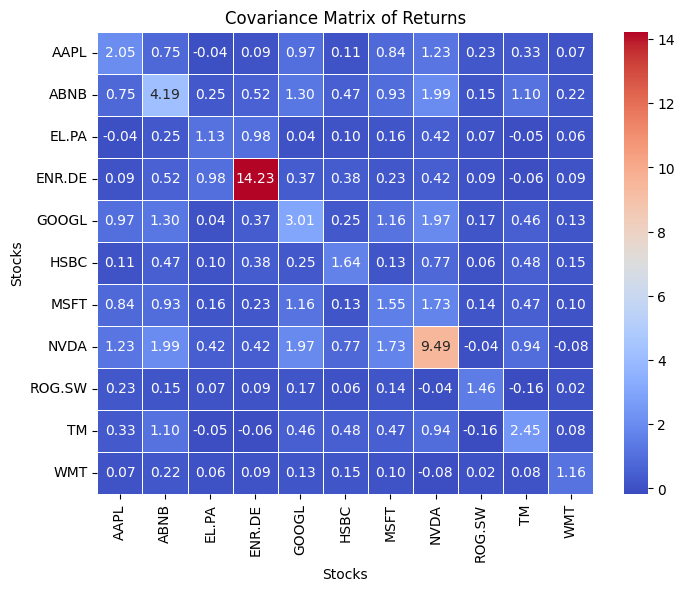

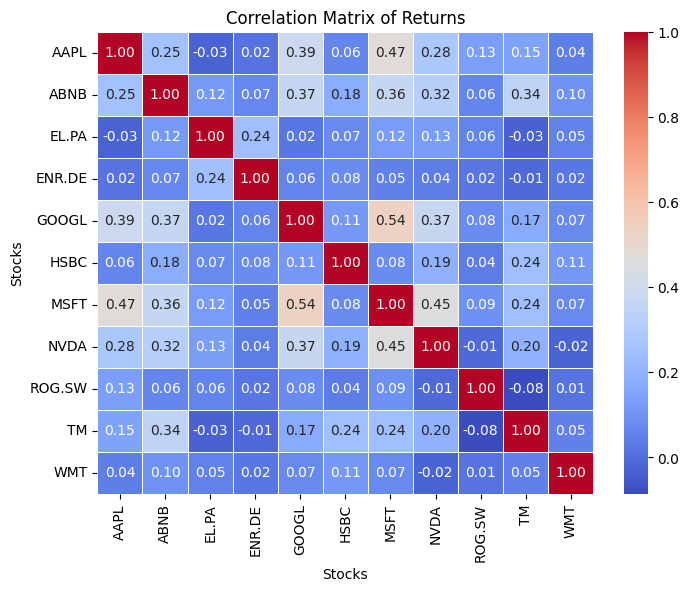

In [49]:
def plot_heatmap(matrix: pd.DataFrame, title: str) -> None:
    """
    This function plots a heatmap of the given matrix.

    Args:
        matrix (pd.DataFrame): The matrix to be plotted.
        title (str): The title of the plot.
    """
    # Create a heatmap
    plt.figure(figsize=(8, 6))  
    # Create a heatmap plot
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    
    # Set the title of the plot
    plt.title(title)
    plt.xlabel('Stocks')
    plt.ylabel('Stocks')
    
    # Display the plot
    plt.show()

# Plot the covariance matrix
plot_heatmap(covariance_matrix, "Covariance Matrix of Returns")
# Plot the correlation matrix
plot_heatmap(correlation_matrix, "Correlation Matrix of Returns")